In [209]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

import warnings

warnings.filterwarnings('ignore')

sns.set_theme(style='white')

In [210]:
raw_data = load_iris(as_frame=True)
raw_data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [211]:
X = pd.DataFrame(data=raw_data['data'])
y = pd.DataFrame(data=raw_data['target'])

data = pd.concat(objs=(X, y), axis=1)

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [213]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0


In [214]:
data.rename(
    columns = {'sepal length (cm)' : 'sepal_length',
     'sepal width (cm)': 'sepal_width',
     'petal length (cm)': 'petal_length',
     'petal width (cm)': 'petal_width',},
    inplace=True
)

data['target_names'] = data['target'].map(lambda val: raw_data.target_names[val])
data

,sepal_length,sepal_width,petal_length,petal_width,target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


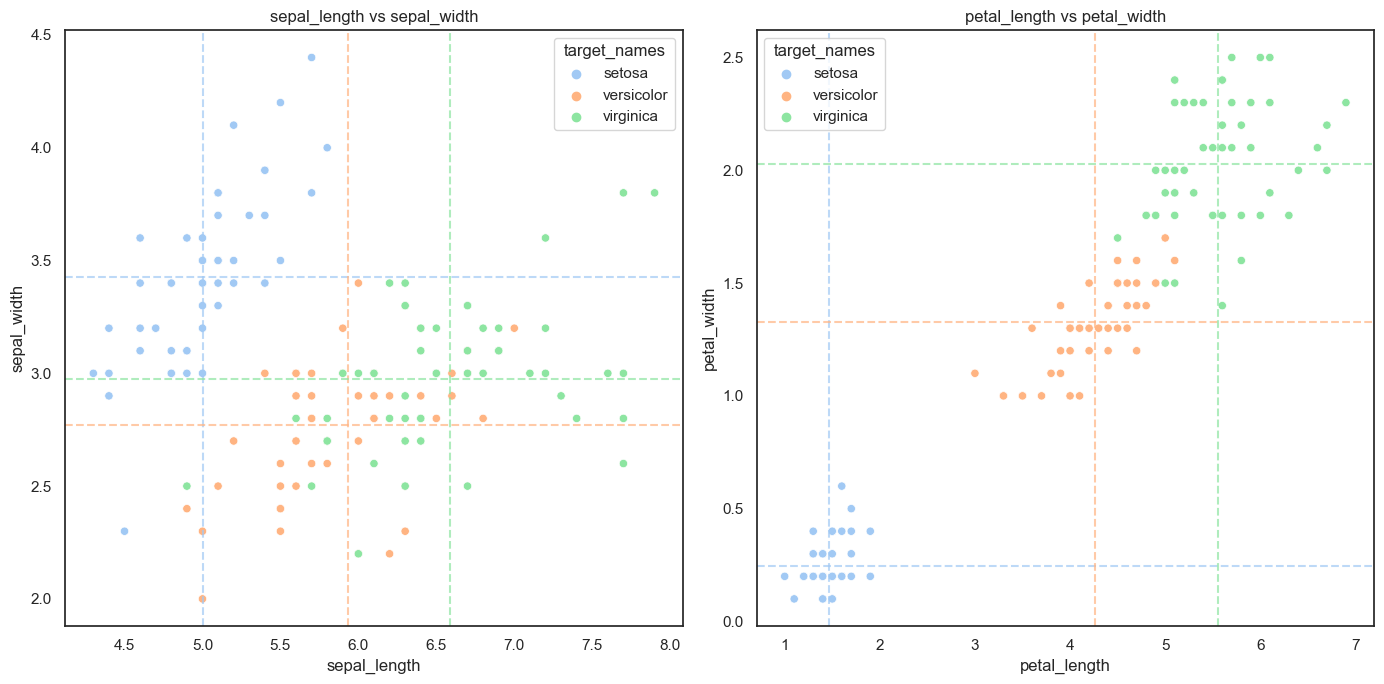

In [ ]:

def iris_scatterplot(ds, xs, ys):
    if len(xs) != len(ys):
        return None
    
    fig, ax = plt.subplots(nrows=1, ncols=len(xs), figsize=(14,7))
    ax = ax.flatten()
    
    for idx, (x,y) in enumerate(zip(xs,ys)):
        sns.scatterplot(data=ds,
                        x = x,
                        y = y,
                        hue = 'target_names',
                        palette='pastel',
                        ax=ax[idx])

        for i, species in enumerate(data['target_names'].unique()):
            condition = data['target_names'] == species
            subset = data.loc[condition,:]
            
            mean_sl = subset[x].mean() #x
            mean_sw = subset[y].mean() #y
            
            ax[idx].axvline(mean_sl, linestyle='--', color=sns.color_palette('pastel')[i], alpha = 0.7)
            ax[idx].axhline(mean_sw, linestyle='--', color=sns.color_palette('pastel')[i], alpha = 0.7)
            
        ax[idx].set_title(f'{x} vs {y}')
    plt.tight_layout()
    
iris_scatterplot(ds=data, xs = ('sepal_length', 'petal_length'),
                          ys = ('sepal_width', 'petal_width'))

<Figure size 1000x800 with 0 Axes>

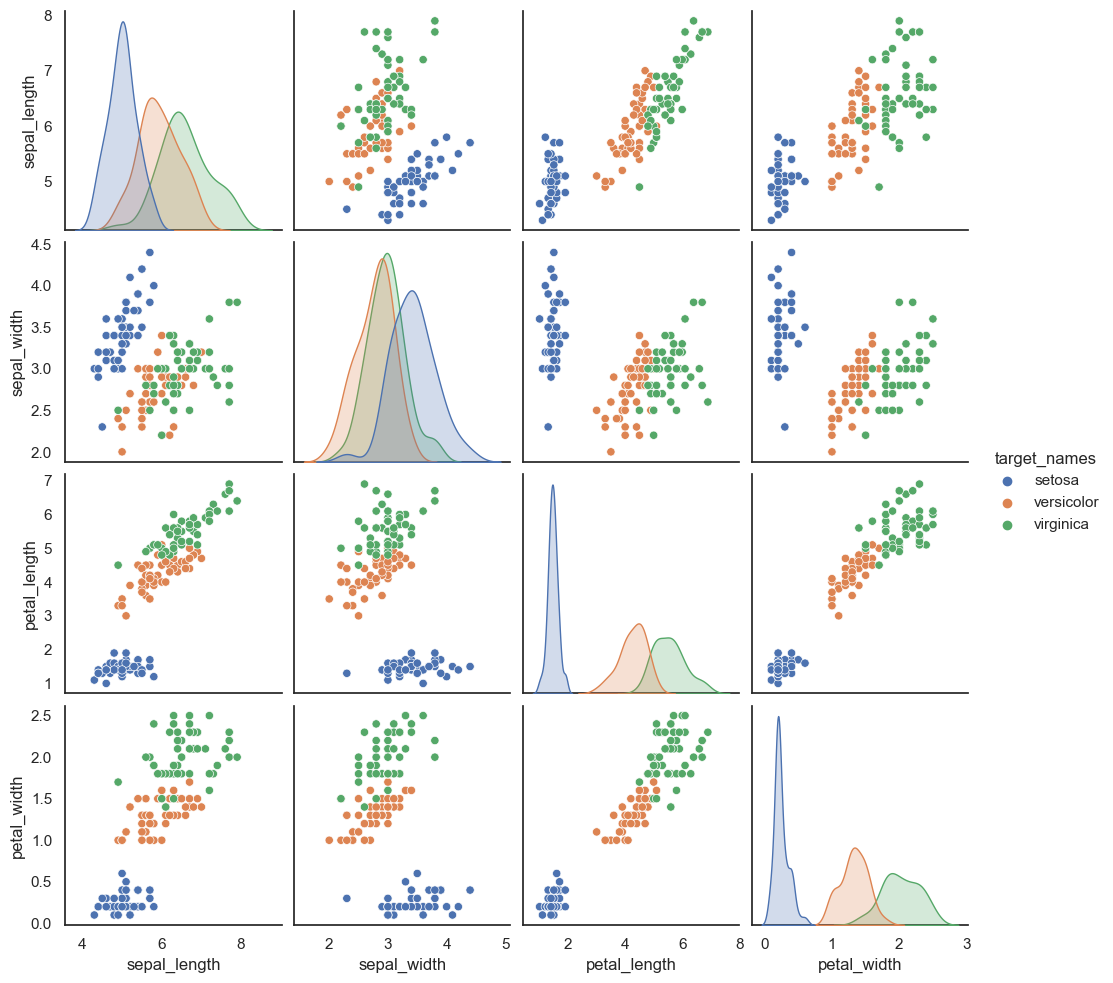

In [216]:
plt.figure(figsize=(10,8))
sns.pairplot(data=data.drop('target', axis=1),
             hue='target_names')

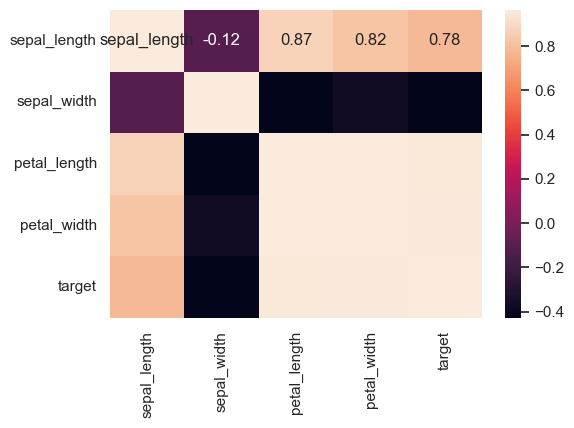

In [217]:
fig, ax = plt.subplots(figsize=(6,4))
numerical_subset = data.select_dtypes(include=[int, float])
                        
numerical_corr = numerical_subset.corr()
min_corr = numerical_corr.min().min()
max_corr = numerical_corr[numerical_corr < 1].max().max()
annot_matrix = numerical_corr.round(2).astype(str)
np.fill_diagonal(annot_matrix.values, [f'{feature}' for feature in numerical_corr.columns])

sns.heatmap(data=numerical_corr,
            annot=annot_matrix,
            fmt='',
            vmax=max_corr,
            vmin=min_corr,
            ax=ax)
plt.show()

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             confusion_matrix,
                             classification_report)

In [219]:
def manage_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    conf_train = confusion_matrix(y_train, y_pred_train)
    conf_test = confusion_matrix(y_test, y_pred_test)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    
    print("\nConfusion Matrix:")
    sns.heatmap(conf_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(conf_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()
    
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())

    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())


    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, F1_train, F1_test ]
    return model_score
    

In [220]:
X = data["sepal_length sepal_width petal_length petal_width".split(' ')].values
y = data.target

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Tuning model log_reg...
Best params: {'solver': 'saga', 'penalty': 'l1', 'C': 100}

Confusion Matrix:


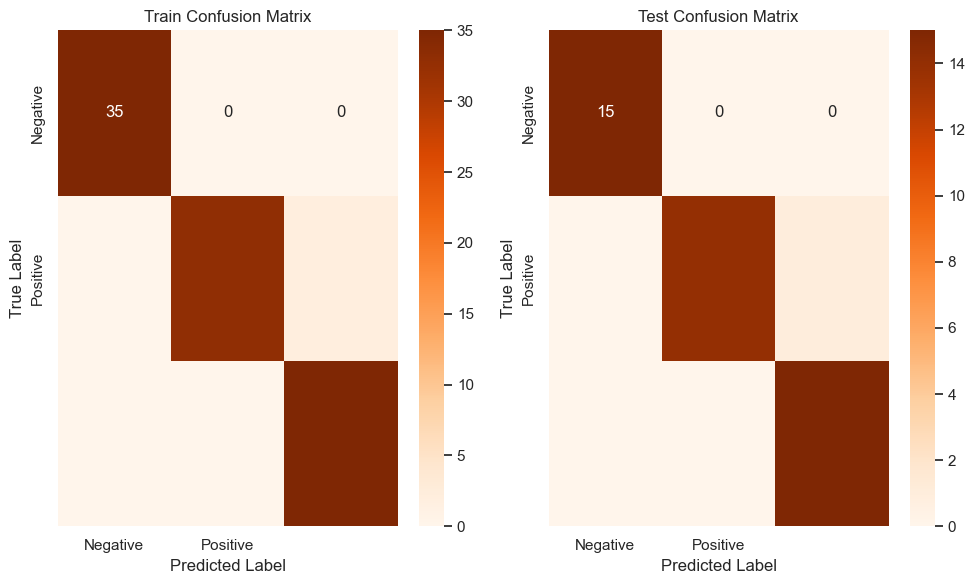


Train Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    1        | 1        |   1        |  35        |
| 1            |    1        | 0.942857 |   0.970588 |  35        |
| 2            |    0.945946 | 1        |   0.972222 |  35        |
| accuracy     |    0.980952 | 0.980952 |   0.980952 |   0.980952 |
| macro avg    |    0.981982 | 0.980952 |   0.980937 | 105        |
| weighted avg |    0.981982 | 0.980952 |   0.980937 | 105        |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 15        |
| 1            |    1        | 0.933333 |   0.965517 | 15        |
| 2            |    0.9375   | 1        |   0.967742 | 15        |
| accuracy     |    0.977778 | 0.977778 |   0.977778 |  0.9777

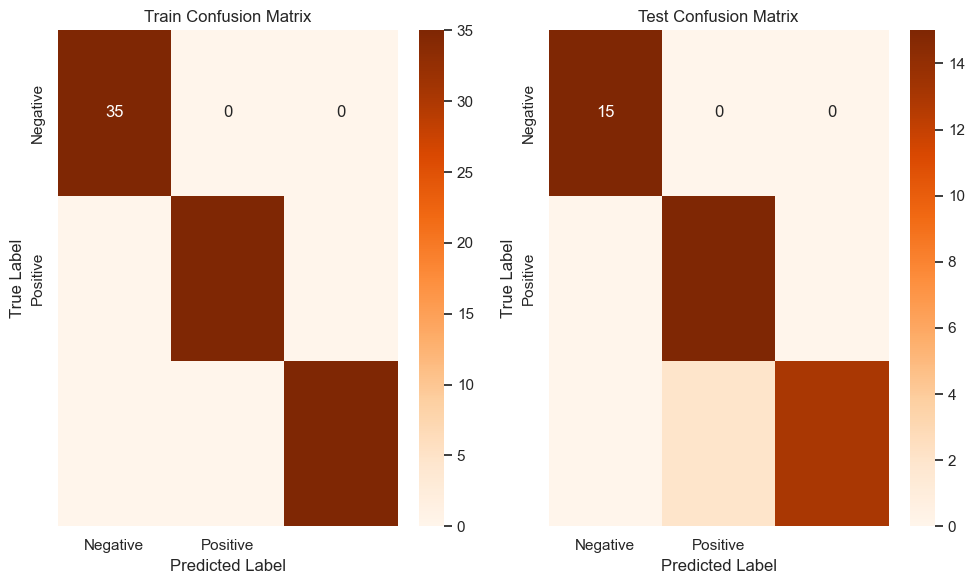


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        35 |
| 1            |           1 |        1 |          1 |        35 |
| 2            |           1 |        1 |          1 |        35 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |       105 |
| weighted avg |           1 |        1 |          1 |       105 |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 15        |
| 1            |    0.882353 | 1        |   0.9375   | 15        |
| 2            |    1        | 0.866667 |   0.928571 | 15        |
| accuracy     |    0.955556 | 0.955556 |   0.955556 |  0.955556 |
| m

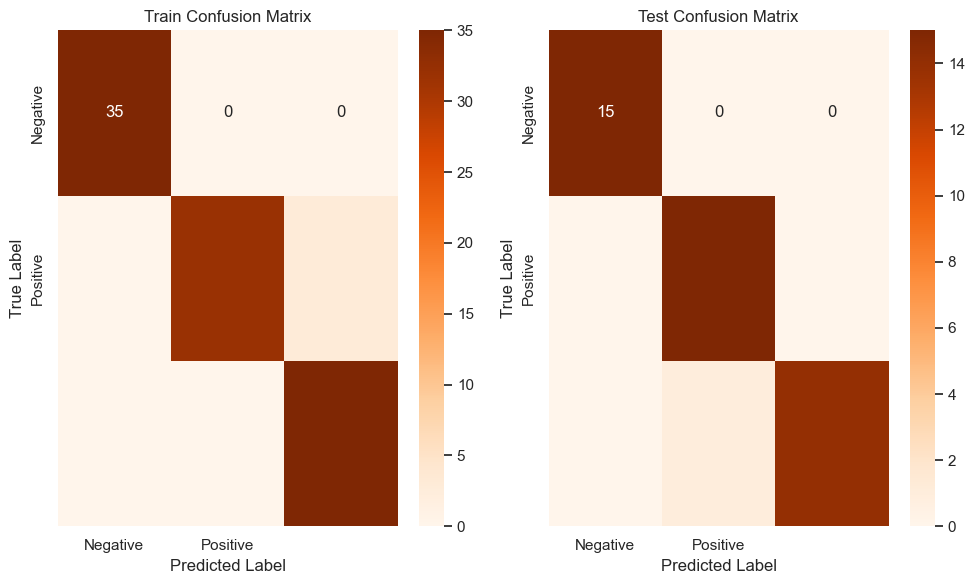


Train Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    1        | 1        |   1        |  35        |
| 1            |    1        | 0.914286 |   0.955224 |  35        |
| 2            |    0.921053 | 1        |   0.958904 |  35        |
| accuracy     |    0.971429 | 0.971429 |   0.971429 |   0.971429 |
| macro avg    |    0.973684 | 0.971429 |   0.971376 | 105        |
| weighted avg |    0.973684 | 0.971429 |   0.971376 | 105        |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 15        |
| 1            |    0.9375   | 1        |   0.967742 | 15        |
| 2            |    1        | 0.933333 |   0.965517 | 15        |
| accuracy     |    0.977778 | 0.977778 |   0.977778 |  0.9777

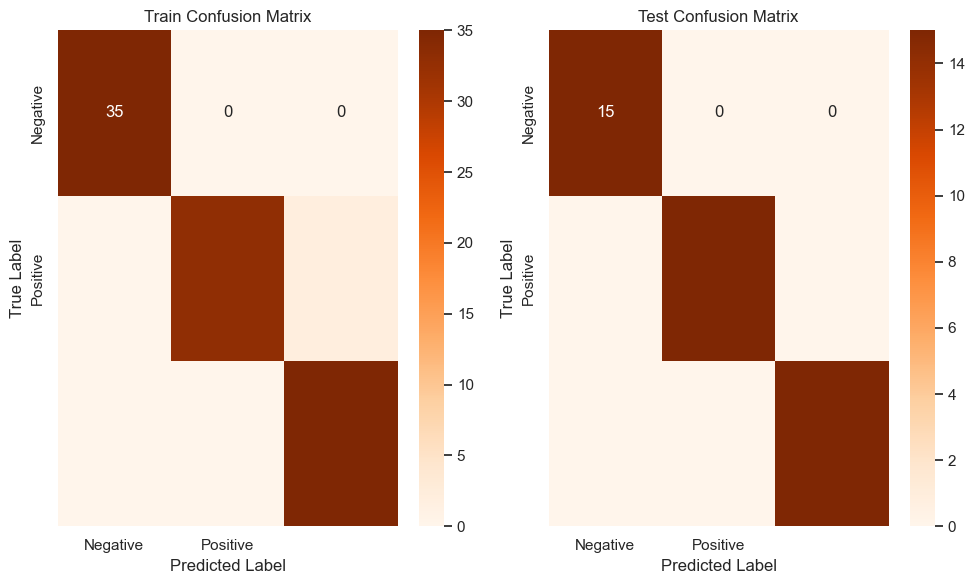


Train Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    1        | 1        |   1        |  35        |
| 1            |    1        | 0.942857 |   0.970588 |  35        |
| 2            |    0.945946 | 1        |   0.972222 |  35        |
| accuracy     |    0.980952 | 0.980952 |   0.980952 |   0.980952 |
| macro avg    |    0.981982 | 0.980952 |   0.980937 | 105        |
| weighted avg |    0.981982 | 0.980952 |   0.980937 | 105        |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        15 |
| 1            |           1 |        1 |          1 |        15 |
| 2            |           1 |        1 |          1 |        15 |
| accuracy     |           1 |        1 |          1 |        

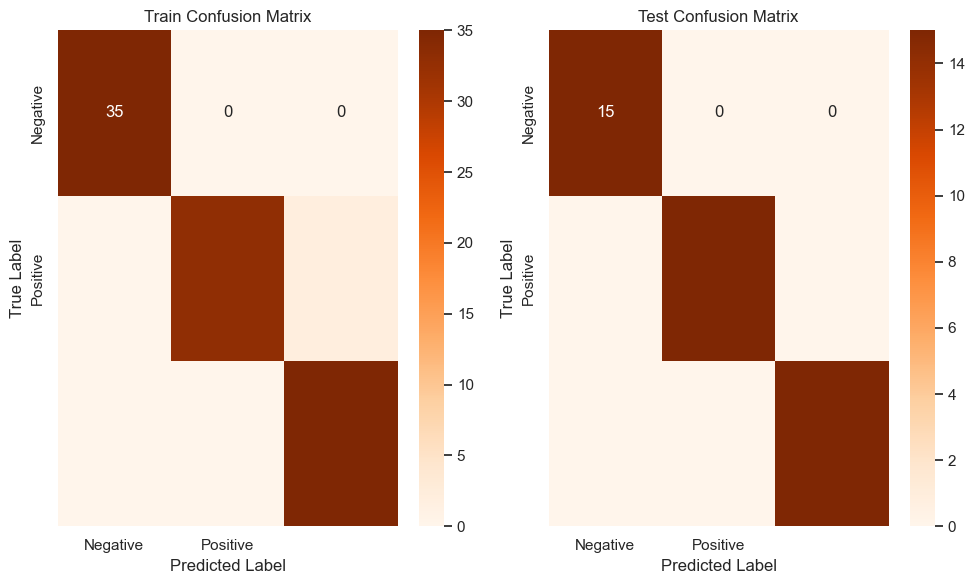


Train Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    1        | 1        |   1        |  35        |
| 1            |    1        | 0.942857 |   0.970588 |  35        |
| 2            |    0.945946 | 1        |   0.972222 |  35        |
| accuracy     |    0.980952 | 0.980952 |   0.980952 |   0.980952 |
| macro avg    |    0.981982 | 0.980952 |   0.980937 | 105        |
| weighted avg |    0.981982 | 0.980952 |   0.980937 | 105        |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        15 |
| 1            |           1 |        1 |          1 |        15 |
| 2            |           1 |        1 |          1 |        15 |
| accuracy     |           1 |        1 |          1 |        

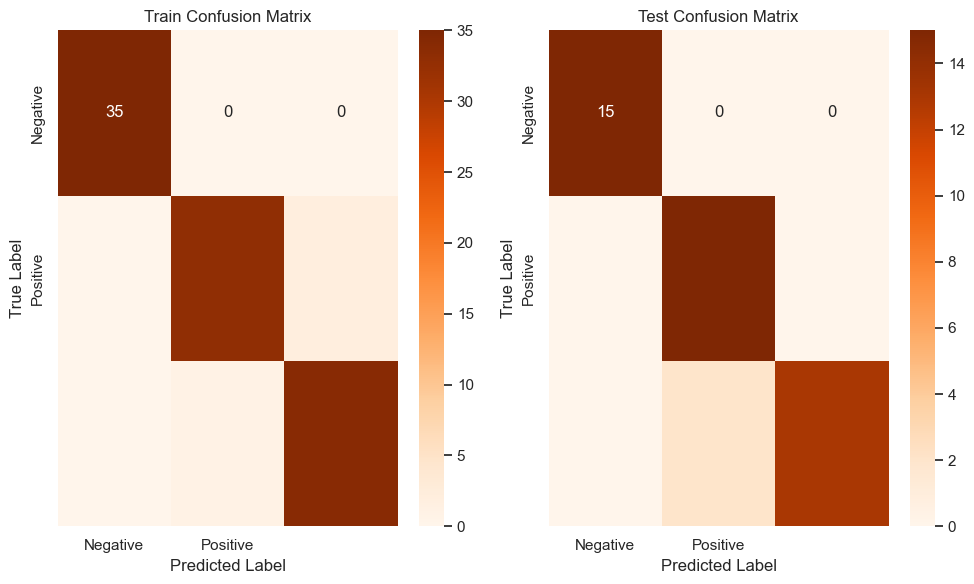


Train Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    1        | 1        |   1        |  35        |
| 1            |    0.970588 | 0.942857 |   0.956522 |  35        |
| 2            |    0.944444 | 0.971429 |   0.957746 |  35        |
| accuracy     |    0.971429 | 0.971429 |   0.971429 |   0.971429 |
| macro avg    |    0.971678 | 0.971429 |   0.971423 | 105        |
| weighted avg |    0.971678 | 0.971429 |   0.971423 | 105        |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 15        |
| 1            |    0.882353 | 1        |   0.9375   | 15        |
| 2            |    1        | 0.866667 |   0.928571 | 15        |
| accuracy     |    0.955556 | 0.955556 |   0.955556 |  0.9555

In [222]:
models = dict(
    log_reg = LogisticRegression(),
    tree = DecisionTreeClassifier(),
    random_forest = RandomForestClassifier(),
    svc = SVC(),
    mlp = MLPClassifier(),
    gauss = GaussianNB()
)

param_grid = {
    'log_reg': {
        'C': [.0001, .01, .1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['lbfgs', 'liblinear', 'saga']
        },
    
    'tree': {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2,5,10,20],
        'min_samples_leaf': [1,2,5,20],
        'criterion': ['gini', 'entropy']},
    
    'random_forest': {
        'n_estimators': [50,100,200,350],
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2,5,10,20],
        'min_samples_leaf': [1,2,5,20],
        'max_features': ['auto', 'sqrt', 'log2']
        },
    
    'svc': {
        'C': [.01, .1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', .01, .1, 1],
        'degree': [2,3,4]},
    
    'mlp': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': 	['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd', 'lbfgs'],
        'alpha': [.0001,.001, .01, .1],
        'learning_rate': ['constant', 'adaptive', 'invscaling']},
    'gauss': { 'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
}

index = ['precision_train', 'precision_test', 'recall_train', 'recall_test', 
         'accuracy_train', 'accuracy_test', 'F1_train', 'F1_test']
summary = pd.DataFrame(
    index = index
)
rsf = RepeatedStratifiedKFold(random_state=132)
for model_name, model_e in models.items():
    print(f'Tuning model {model_name}...')
    rg_search = RandomizedSearchCV(model_e,
                                    param_distributions=param_grid[model_name],
                                    cv=rsf,
                                    scoring='accuracy',
                                    n_iter=20,
                                    n_jobs=-1,
                                    random_state=42)

    rg_search.fit(X_train, y_train)
    best_params = rg_search.best_params_
    
    print('Best params:', best_params)
    model_e.set_params(**best_params)
    summary[model_name] = manage_model(model_e, X_train, X_test, y_train, y_test)

In [223]:
summary

,log_reg,tree,random_forest,svc,mlp,gauss
precision_train,0.981982,1.000000,0.973684,0.981982,0.981982,0.971678
precision_test,0.979167,0.960784,0.979167,1.000000,1.000000,0.960784
recall_train,0.980952,1.000000,0.971429,0.980952,0.980952,0.971429
recall_test,0.977778,0.955556,0.977778,1.000000,1.000000,0.955556
accuracy_train,0.980952,1.000000,0.971429,0.980952,0.980952,0.971429
accuracy_test,0.977778,0.955556,0.977778,1.000000,1.000000,0.955556
F1_train,0.980937,1.000000,0.971376,0.980937,0.980937,0.971423
F1_test,0.977753,0.955357,0.977753,1.000000,1.000000,0.955357


In [224]:
vertical_con = summary.index.str.contains('test')
summary.loc[vertical_con,:]

,log_reg,tree,random_forest,svc,mlp,gauss
precision_test,0.979167,0.960784,0.979167,1.0,1.0,0.960784
recall_test,0.977778,0.955556,0.977778,1.0,1.0,0.955556
accuracy_test,0.977778,0.955556,0.977778,1.0,1.0,0.955556
F1_test,0.977753,0.955357,0.977753,1.0,1.0,0.955357
